<center>
<img src="https://i.ibb.co/b3T5hkz/logo.png" alt="logo" border="0" width=600>


---
## 02. A Convolutional Image Classification Neural Network using `AstroNN`


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Abstract

In this notebook we will train a convolutional neural network to classify images using the library `astroNN`.

---

In [1]:
!pip install tensorflow
!pip install tensorflow_probability
!pip install git+https://github.com/henrysky/astroNN.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/henrysky/astroNN.git to /tmp/pip-req-build-pv1rvzu9
  Running command git clone --filter=blob:none --quiet https://github.com/henrysky/astroNN.git /tmp/pip-req-build-pv1rvzu9
  Resolved https://github.com/henrysky/astroNN.git to commit afa7daed2894e519b09ce0a292205ac9692999cc
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 5.0 MB/s eta 0:00:00
  Created wheel for astroNN: filename=astroNN-1.2.dev0-py3-none-any.whl size=9336517 sha256=4331e735057bfbfceefacae6

---

## The Dataset

The Galaxy10 SDSS dataset contains 21785 colored images (g, r and i band) of galaxies with a size of 69x69 pixels separated in 10 classes:



- Class 0 (3461 images): Disk, Face-on, No Spiral
- Class 1 (6997 images): Smooth, Completely round
- Class 2 (6292 images): Smooth, in-between round
- Class 3 (394 images): Smooth, Cigar shaped
- Class 4 (1534 images): Disk, Edge-on, Rounded Bulge
- Class 5 (17 images): Disk, Edge-on, Boxy Bulge
- Class 6 (589 images): Disk, Edge-on, No Bulge
- Class 7 (1121 images): Disk, Face-on, Tight Spiral
- Class 8 (906 images): Disk, Face-on, Medium Spiral
- Class 9 (519 images): Disk, Face-on, Loose Spiral

These images come from the [Sloan Digital Sky Survey (SDSS)](http://www.sdss.org/) and the labels come from [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/).

This dataset can be downloaded from [here](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html) or directly from [here](http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5)

### Reading the dataset

The dataset is given in a .h5 file. Therefore, we will use the library `h5py`to read it,


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion


# To get the images and labels from file
with h5py.File('/content/drive/MyDrive/Colab Notebooks/Neural Networks/06. Convolutional NN 02/Galaxy10SDSS.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
  


galaxyClass = ['Disk, Face-on, No Spiral',
               'Smooth, Completely round',
               'Smooth, in-between round',
               'Smooth, Cigar shaped',
               'Disk, Edge-on, Rounded Bulge',
               'Disk, Edge-on, Boxy Bulge',
               'Disk, Edge-on, No Bulge',
               'Disk, Face-on, Tight Spiral',
               'Disk, Face-on, Medium Spiral',
               'Disk, Face-on, Loose Spiral']


In [4]:
print(images.shape)
print(labels.shape)

(21785, 69, 69, 3)
(21785,)


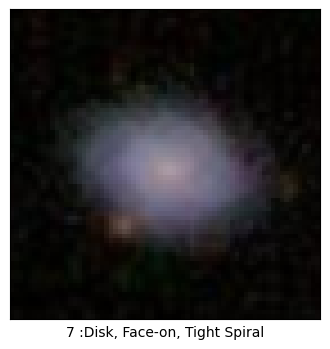

In [5]:
i = int(np.random.rand(1)*21785)
plt.figure(figsize=(4,5))
plt.imshow(images[i])
plt.xticks([])
plt.yticks([])
plt.xlabel(f'{labels[i]:.0f} :'+ galaxyClass[labels[i]])
plt.show()

In order to classify the images, we will transform the images and the labels into float numbers


In [6]:
# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

Now we will split the dataset into training and test subsets

In [7]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

---

## The Classification Neural Network

We will use the Galaxy10CNN neural network from the AstroNN library to create the model. 

In [8]:
# To create a neural network instance
galaxy10net = Galaxy10CNN()

We can visualize the complete structure of the model


In [11]:
# print model summary before training
galaxy10net.keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 69, 69, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 69, 69, 8)         224       
                                                                 
 activation (Activation)     (None, 69, 69, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 16)        1168      
                                                                 
 activation_1 (Activation)   (None, 69, 69, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                             

Using the method `.max_epochs` we set the number of epochs and the method `.train()` to train the model.

In [10]:
# set maximium epochs the neural network can run, set 5 to get quick result
galaxy10net.max_epochs = 5

# To train the nerual net
# astroNN will normalize the data by default
galaxy10net.train(train_images, train_labels)

<ipython-input-10-87b79db8b84e>:6: UserWarning: Call to function train() is deprecated and will be removed in future. Use fit() instead.


Number of Training Data: 17646, Number of Validation Data: 1960
====Message from Normalizer====
You selected mode: 255
Featurewise Center: {'input': False}
Datawise Center: {'input': False} 
Featurewise std Center: {'input': False}
Datawise std Center: {'input': False} 
====Message ends====
====Message from Normalizer====
You selected mode: 0
Featurewise Center: {'output': False}
Datawise Center: {'output': False} 
Featurewise std Center: {'output': False}
Datawise std Center: {'output': False} 
====Message ends====
Epoch 1/5
275/275 - 108s - loss: 1.5556 - categorical_accuracy: 0.3989 - val_loss: 1.2572 - val_categorical_accuracy: 0.4797 - lr: 0.0050 - 108s/epoch - 392ms/step
Epoch 2/5
275/275 - 100s - loss: 1.1757 - categorical_accuracy: 0.5657 - val_loss: 1.1005 - val_categorical_accuracy: 0.5797 - lr: 0.0050 - 100s/epoch - 365ms/step
Epoch 3/5
275/275 - 103s - loss: 1.0844 - categorical_accuracy: 0.6049 - val_loss: 1.0529 - val_categorical_accuracy: 0.6000 - lr: 0.0050 - 103s/epoch

---
## Testing the Model

Now we will use the test subsets to probe the model. Using the '.evaluate()' method, we obtain the accuracy of the model (using the metric defined above),

In [12]:
test_loss, test_acc = galaxy10net.evaluate(test_images,  test_labels)

print('\nTest accuracy:', test_acc)

Starting Evaluation
34/34 [==============================] - 6s 166ms/step - loss: 0.9299 - categorical_accuracy: 0.6903
Completed Evaluation, 5.78s elapsed

Test accuracy: categorical_accuracy


Since this a classification problem, it is also possible to build a confusion matrix to show the result and measure the precision of the model,

<ipython-input-13-1219a58a0eec>:3: UserWarning: Call to function test() is deprecated and will be removed in future. Use predict() instead.
Prediction progress: 100%|██████████| 2179/2179 [00:04<00:00, 513.76sample/s]


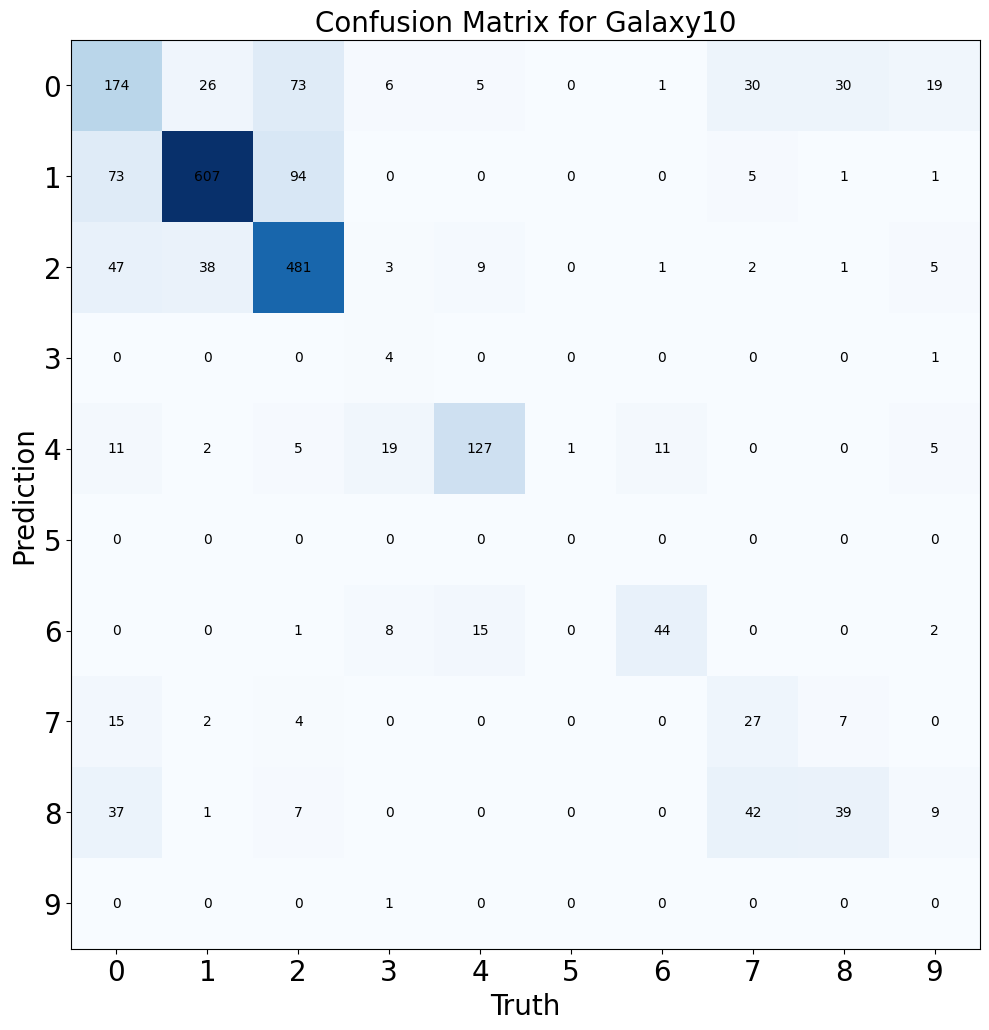

In [13]:
# After the training, you can test the neural net performance
# Please notice predicted_labels are labels predicted from neural network. test_labels are ground truth from the dataset
predicted_labels = galaxy10net.test(test_images)

# Convert predicted_labels to class
prediction_class = np.argmax(predicted_labels, axis=1)

# Convert test_labels to class
test_class = np.argmax(test_labels, axis=1)

# Prepare a confusion matrix
confusion_matrix = np.zeros((10,10))

# create the confusion matrix
for counter, i in enumerate(prediction_class):
    confusion_matrix[i, test_class[counter]] += 1

# Plot the confusion matrix
galaxy10_confusion(confusion_matrix)